# Benchmark for the different removers

In [76]:
# Import dependencies
import sys
import os

# Add the parent directory to sys.path
module_path = os.path.abspath(os.path.join("../"))
if module_path not in sys.path:
    sys.path.append(module_path)
    
import time
import cv2
import pandas as pd
from video_processor.processor import BenardSupressor
from detectors import YOLODetector, RedCapDetector 
from segmentors import YoloSegmentor
from removers import BlurringRemover, OpenCvInpaintingRemover, LamaInpaintingRemover, BetterLamaInpaintingRemover
from skimage.metrics import structural_similarity as ssim
import numpy as np
import matplotlib.pyplot as plt
from ipywidgets import interact
import math
import torch
import numpy as np
from numpy import cov, trace, iscomplexobj
from scipy.linalg import sqrtm
from torchvision.models import inception_v3
from torchvision.transforms import ToTensor, Resize, Normalize, Compose
from PIL import Image

%matplotlib inline

In [85]:
model = inception_v3(pretrained=True, transform_input=False)
model.fc = torch.nn.Identity()  # Remove the final classification layer
model.eval()

def calculate_fid_torch(image1, image2):
    """
    Calculate FID score using PyTorch-based InceptionV3.

    Parameters:
        image1 (PIL.Image or numpy array): Ground truth image (without individual).
        image2 (PIL.Image or numpy array): Processed image.

    Returns:
        float: FID score.
    """

    # Ensure the model is initialized


    # Transform to match InceptionV3 input
    transform = Compose([
        Resize((299, 299)),
        ToTensor(),
        Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ])

    # Preprocess images
    def preprocess_image(image):
        from PIL import Image
        image = Image.fromarray(image) if isinstance(image, np.ndarray) else image
        return transform(image).unsqueeze(0)  # Add batch dimension

    image1 = preprocess_image(image1)
    image2 = preprocess_image(image2)

    # Extract features
    with torch.no_grad():
        act1 = model(image1).cpu().numpy()
        act2 = model(image2).cpu().numpy()

    # Calculate mean and covariance
    def calculate_covariance(features):
        if features.shape[0] == 1:  # Single vector case
            return np.atleast_2d(np.cov(features, rowvar=False))
        return np.cov(features, rowvar=False)

    mu1, sigma1 = act1.mean(axis=0), calculate_covariance(act1)
    mu2, sigma2 = act2.mean(axis=0), calculate_covariance(act2)

    # Calculate FID
    ssdiff = np.sum((mu1 - mu2) ** 2.0)

    try:
        covmean = sqrtm(sigma1.dot(sigma2))
    except ValueError as e:
        raise ValueError(f"Covariance matrices may be invalid. sigma1: {sigma1.shape}, sigma2: {sigma2.shape}") from e

    if iscomplexobj(covmean):
        covmean = covmean.real

    fid = ssdiff + trace(sigma1 + sigma2 - 2.0 * covmean)
    return fid


In [86]:
def mse(imageA, imageB):
    return np.mean((imageA.astype("float") - imageB.astype("float")) ** 2)


def psnr(imageA, imageB):
    mse_value = np.mean((imageA - imageB) ** 2, axis=(0, 1))  # Channel-wise MSE
    max_pixel = 255.0
    psnr_value = 20 * np.log10(max_pixel / np.sqrt(mse_value))
    return psnr_value.mean()

def normalized_cross_correlation(imageA, imageB):
    ncc = []
    for channel in range(imageA.shape[2]):
        a = imageA[:, :, channel]
        b = imageB[:, :, channel]
        a = (a - np.mean(a)) / np.std(a)
        b = (b - np.mean(b)) / np.std(b)
        ncc.append(np.mean(a * b))
    return np.mean(ncc)

def compare_histograms(imageA, imageB, method=cv2.HISTCMP_CORREL):
    scores = []
    for channel in range(imageA.shape[2]):
        histA = cv2.calcHist([imageA], [channel], None, [256], [0, 256])
        histB = cv2.calcHist([imageB], [channel], None, [256], [0, 256])
        histA = cv2.normalize(histA, histA).flatten()
        histB = cv2.normalize(histB, histB).flatten()
        scores.append(cv2.compareHist(histA, histB, method))
    return np.mean(scores)

In [87]:
def benchmark_remover_with_process_image(remover, dataset_folder, output_folder, debugging_frames_level="All"):
    # Initialize components for the BenardSupressor
    detector = YOLODetector(device="cuda")
    segmentor = YoloSegmentor(device="cuda")
    benard_supressor = BenardSupressor(detector, segmentor, remover, None)
    
    results = []

    # Process each pair of images
    for i in range(1, 5):  # Assuming 5 pairs of images
        with_path = os.path.join(dataset_folder, f"{i}_with.jpg")
        without_path = os.path.join(dataset_folder, f"{i}_without.jpg")
        
        # Load images
        with_image = cv2.imread(with_path)
        
        without_image = cv2.imread(without_path)
        without_dim = without_image.shape[:2]
        print(without_dim)

        # Process the image with the remover
        _, _, processed_image = benard_supressor.process_image(
            with_image,
            output_folder=output_folder,
            debugging_frames_level=debugging_frames_level
        )
        
        # Resize the processed image to the original size
        processed_image = cv2.resize(processed_image, (without_dim[1], without_dim[0]))
        
        # Plot both images side to side
        plt.figure(figsize=(10, 5))
        plt.subplot(1, 2, 1)
        plt.imshow(cv2.cvtColor(processed_image, cv2.COLOR_BGR2RGB))
        plt.title("Processed Image")
        plt.axis("off")
        
        plt.subplot(1, 2, 2)
        plt.imshow(cv2.cvtColor(without_image, cv2.COLOR_BGR2RGB))
        plt.title("Ground Truth")
        plt.axis("off")
        plt.show()
        
        # Compute the metrics
        similarity = ssim(processed_image, without_image, channel_axis=-1)
        mse_value = mse(processed_image, without_image)
        psnr_value = psnr(processed_image, without_image)
        ncc = normalized_cross_correlation(processed_image, without_image)
        hist_corr = compare_histograms(processed_image, without_image)
        fid = calculate_fid_torch(processed_image, without_image)
        
        results.append({"Image Pair": i, "SSIM": similarity, "MSE": mse_value, "PSNR": psnr_value, "NCC": ncc, "Hist Corr": hist_corr, "FID": fid})

    return results

2024-12-07 20:32:10,214 - modelscope - WARNING - Model revision not specified, use revision: v1.0.0
2024-12-07 20:32:10,674 - modelscope - INFO - initiate model from /users/eleves-b/2022/mathias.perez/.cache/modelscope/hub/damo/cv_fft_inpainting_lama
2024-12-07 20:32:10,675 - modelscope - INFO - initiate model from location /users/eleves-b/2022/mathias.perez/.cache/modelscope/hub/damo/cv_fft_inpainting_lama.
2024-12-07 20:32:10,677 - modelscope - INFO - initialize model from /users/eleves-b/2022/mathias.perez/.cache/modelscope/hub/damo/cv_fft_inpainting_lama
2024-12-07 20:32:10,679 - modelscope - INFO - BaseInpaintingTrainingModule init called, predict_only is False


Loading weights for net_encoder


2024-12-07 20:32:13,051 - modelscope - INFO - BaseInpaintingTrainingModule init done
2024-12-07 20:32:13,052 - modelscope - INFO - loading pretrained model from /users/eleves-b/2022/mathias.perez/.cache/modelscope/hub/damo/cv_fft_inpainting_lama/pytorch_model.pt
2024-12-07 20:32:18,944 - modelscope - WARNING - No preprocessor field found in cfg.
2024-12-07 20:32:18,945 - modelscope - WARNING - No val key and type key found in preprocessor domain of configuration.json file.
2024-12-07 20:32:18,945 - modelscope - WARNING - Cannot find available config to build preprocessor at mode inference, current config: {'model_dir': '/users/eleves-b/2022/mathias.perez/.cache/modelscope/hub/damo/cv_fft_inpainting_lama'}. trying to build by task and model information.
2024-12-07 20:32:18,946 - modelscope - WARNING - No preprocessor key ('FFTInpainting', 'image-inpainting') found in PREPROCESSOR_MAP, skip building preprocessor.
2024-12-07 20:32:18,953 - modelscope - INFO - loading model from dir /users

Evaluating Blurring...
(1600, 1200)
Will run on cuda
Fusing layers... 


INFO:infer_yolo_v7.yolov7.utils.torch_utils:Model Summary: 407 layers, 37620125 parameters, 37620125 gradients, 106.5 GFLOPS


Workflow Untitled run successfully in 807.238654 ms.

0: 640x224 1 person, 37.1ms
Speed: 1.6ms preprocess, 37.1ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 224)
Workflow Untitled run successfully in 3028.057048 ms.


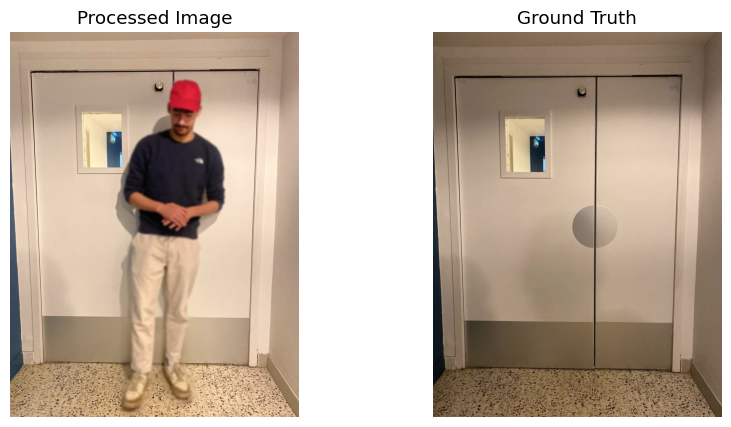

(2040, 942)
Workflow Untitled run successfully in 76.832247 ms.

0: 640x224 1 person, 36.2ms
Speed: 0.6ms preprocess, 36.2ms inference, 6.3ms postprocess per image at shape (1, 3, 640, 224)
Workflow Untitled run successfully in 2878.348942 ms.


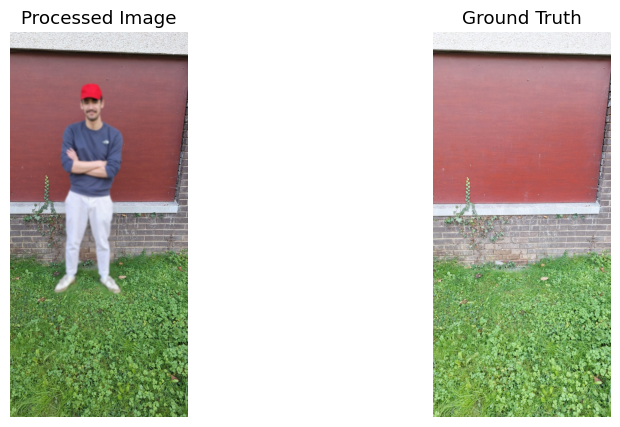

(2040, 942)
Workflow Untitled run successfully in 59.021571 ms.

0: 640x192 1 person, 28.8ms
Speed: 0.8ms preprocess, 28.8ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 192)
Workflow Untitled run successfully in 3048.278834 ms.


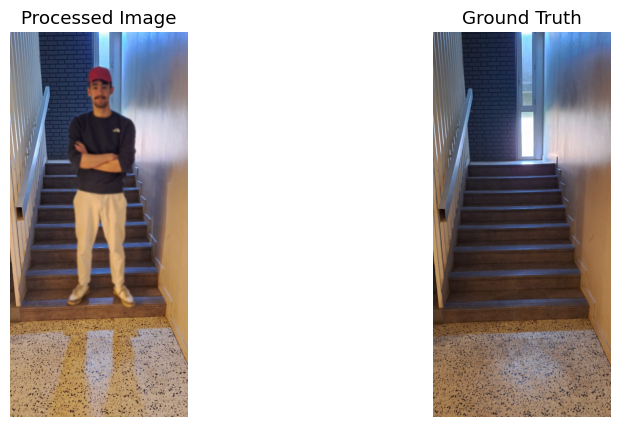

(2040, 942)
Workflow Untitled run successfully in 67.627068 ms.

0: 640x192 1 person, 17.7ms
Speed: 0.7ms preprocess, 17.7ms inference, 4.6ms postprocess per image at shape (1, 3, 640, 192)
Workflow Untitled run successfully in 3146.965763 ms.


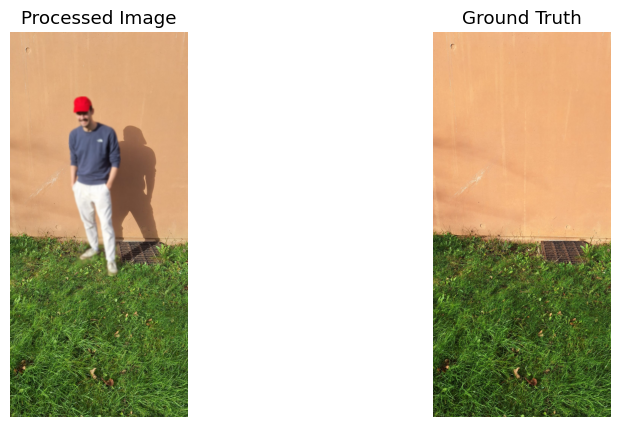

Evaluating OpenCV...
(1600, 1200)
Will run on cuda
Fusing layers... 


INFO:infer_yolo_v7.yolov7.utils.torch_utils:Model Summary: 407 layers, 37620125 parameters, 37620125 gradients, 106.5 GFLOPS


Workflow Untitled run successfully in 959.337507 ms.

0: 640x224 1 person, 31.7ms
Speed: 0.7ms preprocess, 31.7ms inference, 2.4ms postprocess per image at shape (1, 3, 640, 224)
Workflow Untitled run successfully in 2923.409294 ms.


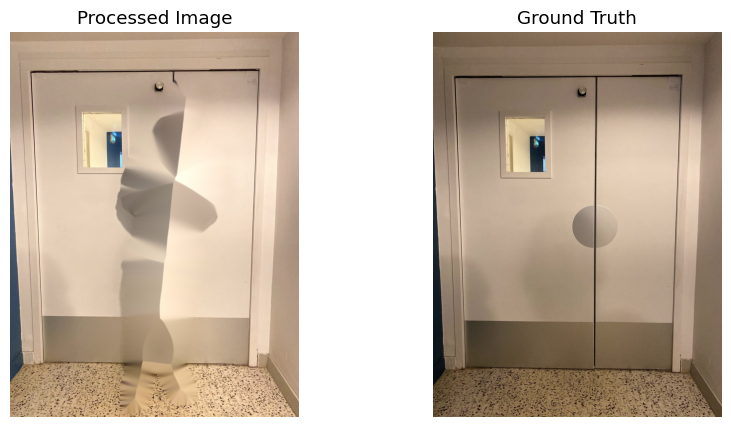

(2040, 942)
Workflow Untitled run successfully in 116.44829 ms.

0: 640x224 1 person, 16.3ms
Speed: 0.7ms preprocess, 16.3ms inference, 15.4ms postprocess per image at shape (1, 3, 640, 224)
Workflow Untitled run successfully in 3019.305337 ms.


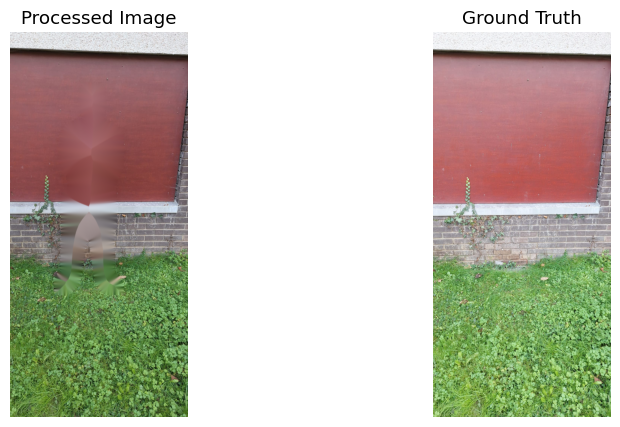

(2040, 942)
Workflow Untitled run successfully in 90.001956 ms.

0: 640x192 1 person, 16.0ms
Speed: 0.7ms preprocess, 16.0ms inference, 15.5ms postprocess per image at shape (1, 3, 640, 192)
Workflow Untitled run successfully in 2759.93907 ms.


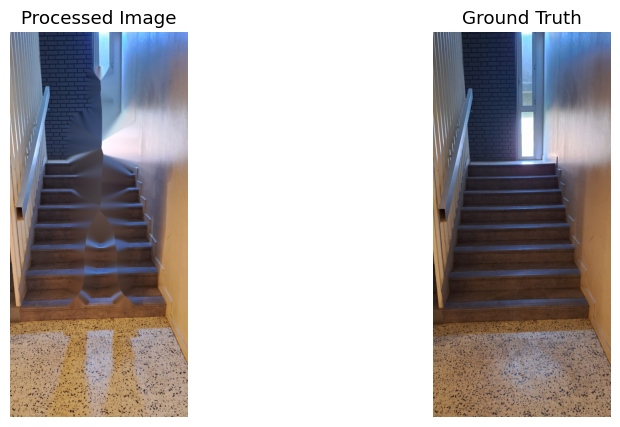

(2040, 942)
Workflow Untitled run successfully in 38.153704 ms.

0: 640x192 1 person, 36.0ms
Speed: 0.6ms preprocess, 36.0ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 192)
Workflow Untitled run successfully in 2883.038199 ms.


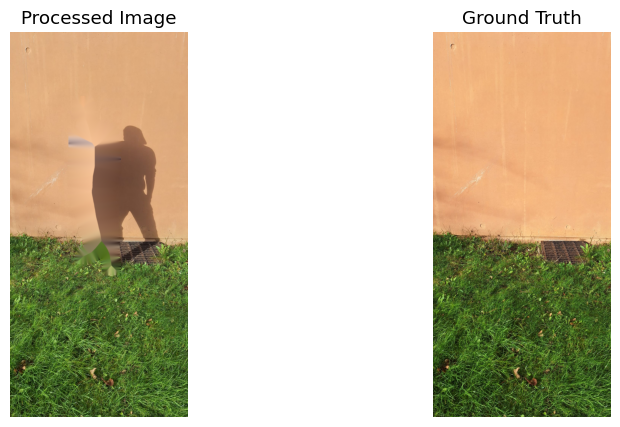

Evaluating Lama...
(1600, 1200)
Will run on cuda
Fusing layers... 


INFO:infer_yolo_v7.yolov7.utils.torch_utils:Model Summary: 407 layers, 37620125 parameters, 37620125 gradients, 106.5 GFLOPS


Workflow Untitled run successfully in 871.909478 ms.

0: 640x224 1 person, 40.4ms
Speed: 0.6ms preprocess, 40.4ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 224)
Workflow Untitled run successfully in 2619.441524 ms.


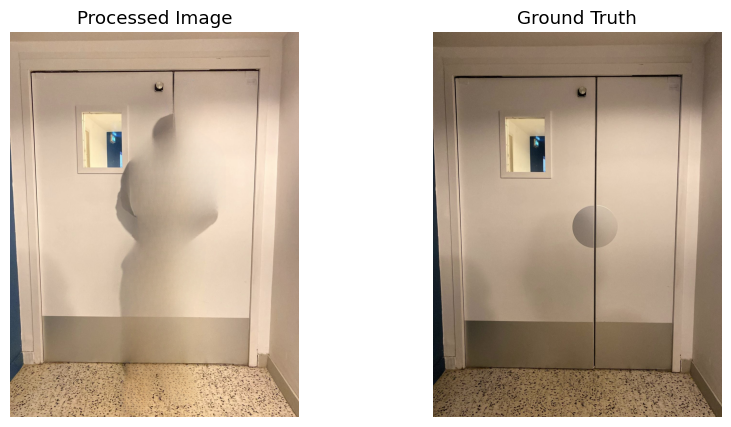

(2040, 942)
Workflow Untitled run successfully in 45.329426 ms.

0: 640x224 1 person, 36.3ms
Speed: 0.8ms preprocess, 36.3ms inference, 2.4ms postprocess per image at shape (1, 3, 640, 224)
Workflow Untitled run successfully in 2915.635959 ms.


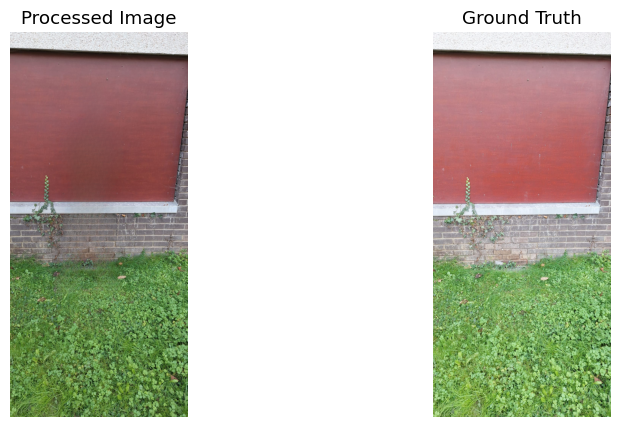

(2040, 942)
Workflow Untitled run successfully in 76.554851 ms.

0: 640x192 1 person, 27.1ms
Speed: 0.6ms preprocess, 27.1ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 192)
Workflow Untitled run successfully in 2867.672905 ms.


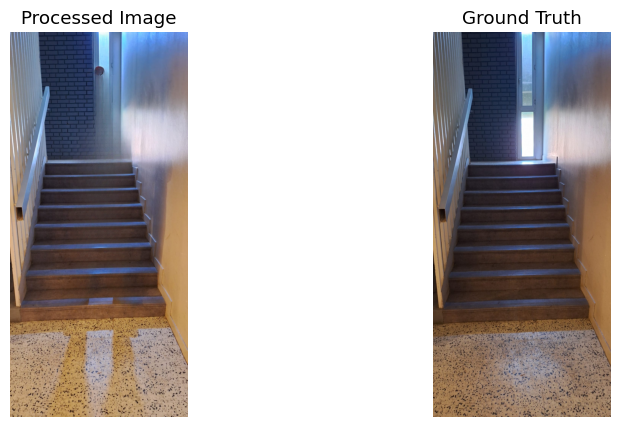

(2040, 942)
Workflow Untitled run successfully in 36.756411 ms.

0: 640x192 1 person, 35.4ms
Speed: 0.7ms preprocess, 35.4ms inference, 6.3ms postprocess per image at shape (1, 3, 640, 192)
Workflow Untitled run successfully in 3038.04507 ms.


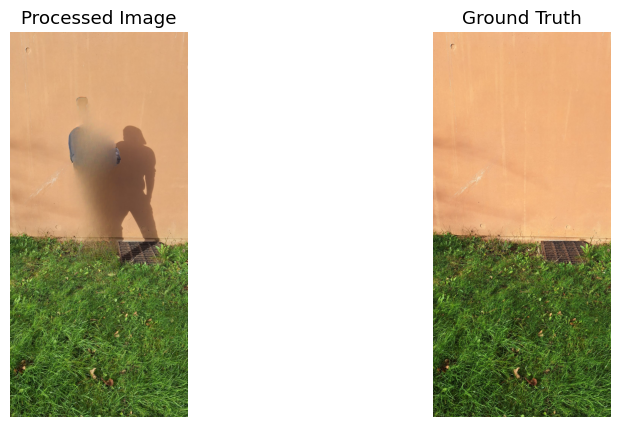

Evaluating BetterLama...
(1600, 1200)
Will run on cuda
Fusing layers... 


INFO:infer_yolo_v7.yolov7.utils.torch_utils:Model Summary: 407 layers, 37620125 parameters, 37620125 gradients, 106.5 GFLOPS


Workflow Untitled run successfully in 1725.710749 ms.

0: 640x224 1 person, 28.9ms
Speed: 0.7ms preprocess, 28.9ms inference, 15.3ms postprocess per image at shape (1, 3, 640, 224)
Workflow Untitled run successfully in 2966.940954 ms.
Original image too large for refinement! Resizing (1600, 1200) to (1095, 821)...


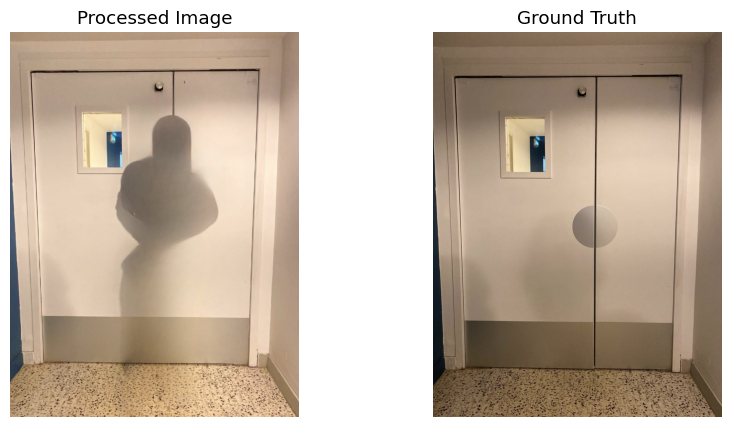

(2040, 942)
Workflow Untitled run successfully in 64.732376 ms.

0: 640x224 1 person, 29.4ms
Speed: 0.8ms preprocess, 29.4ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 224)
Workflow Untitled run successfully in 3144.027844 ms.
Original image too large for refinement! Resizing (2040, 942) to (1396, 644)...


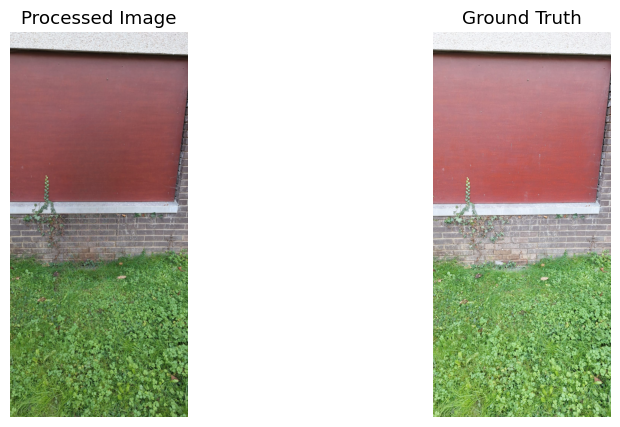

(2040, 942)
Workflow Untitled run successfully in 142.204923 ms.

0: 640x192 1 person, 29.7ms
Speed: 0.7ms preprocess, 29.7ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 192)
Workflow Untitled run successfully in 3127.121467 ms.
Original image too large for refinement! Resizing (2040, 942) to (1396, 644)...


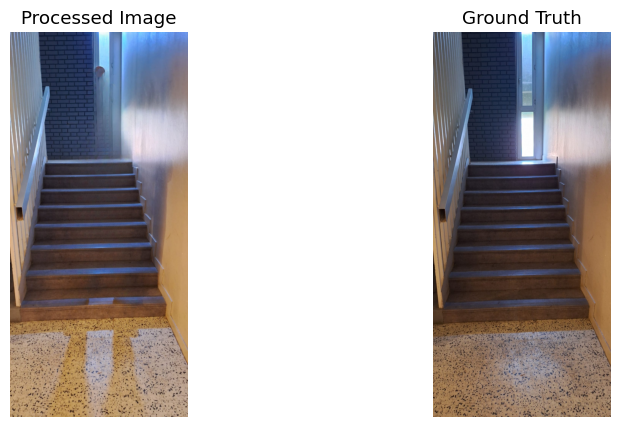

(2040, 942)
Workflow Untitled run successfully in 74.444217 ms.

0: 640x192 1 person, 31.1ms
Speed: 0.7ms preprocess, 31.1ms inference, 15.5ms postprocess per image at shape (1, 3, 640, 192)
Workflow Untitled run successfully in 2968.423367 ms.
Original image too large for refinement! Resizing (2040, 942) to (1396, 644)...


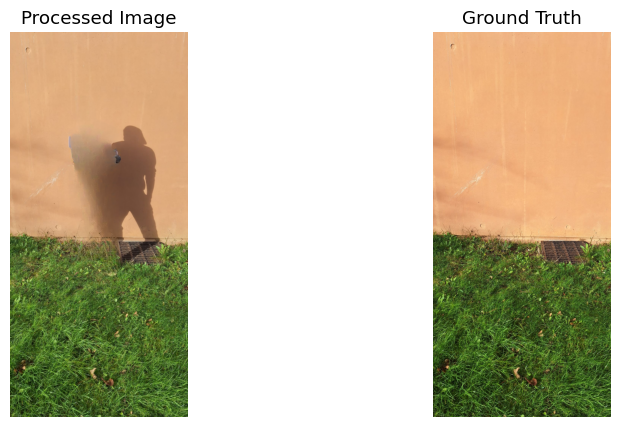

In [88]:
# Define paths
dataset_folder = "../data/mathias.p/INF573_data/Remover_Benchmark"
output_folder = "../data/mathias.p/INF573_data/Remover_Benchmark/"

# Initialize removers
removers = {
    "Blurring": BlurringRemover(),
    "OpenCV": OpenCvInpaintingRemover(),
    "Lama": LamaInpaintingRemover(),
    "BetterLama": BetterLamaInpaintingRemover()
}

# Run benchmarks
all_results = {}
for name, remover in removers.items():
    print(f"Evaluating {name}...")
    results = benchmark_remover_with_process_image(remover, dataset_folder, output_folder, debugging_frames_level="Remover")
    all_results[name] = results


In [94]:
# Flatten results
results_df = pd.DataFrame(
    [
        {"Remover": remover, "Image Pair": res["Image Pair"], "SSIM": res["SSIM"], "MSE": res["MSE"], "PSNR": res["PSNR"], "NCC": res["NCC"], "Hist Corr": res["Hist Corr"], "FID": res["FID"]}
        for remover, results in all_results.items()
        for res in results
    ]
)

# # Display the results
# results_df

# Metrics where higher values are better
higher_is_better = ["SSIM", "PSNR", "NCC", "Hist Corr"]

# Metrics where lower values are better
lower_is_better = ["MSE", "FID"]

# Rank each metric for each image pair
ranked_results = results_df.copy()

for metric in higher_is_better:
    ranked_results[metric + "_Rank"] = ranked_results.groupby("Image Pair")[metric].rank(ascending=False)

for metric in lower_is_better:
    ranked_results[metric + "_Rank"] = ranked_results.groupby("Image Pair")[metric].rank(ascending=True)

# Calculate the mean ranking for each remover
rank_columns = [col for col in ranked_results.columns if "_Rank" in col]
mean_ranking = ranked_results.groupby("Remover")[rank_columns].mean()

# Add a column for the overall mean rank across all metrics
mean_ranking["Overall_Rank"] = mean_ranking.mean(axis=1)

# Display the ranked results and mean rankings
# print("Ranked Results:")
# print(ranked_results)
print("\nMean Rankings:")
print(mean_ranking)


Mean Rankings:
            SSIM_Rank  PSNR_Rank  NCC_Rank  Hist Corr_Rank  MSE_Rank  \
Remover                                                                
BetterLama       1.00       2.50       2.0             2.5      1.25   
Blurring         4.00       2.00       4.0             2.5      4.00   
Lama             2.75       2.75       2.0             2.5      2.25   
OpenCV           2.25       2.75       2.0             2.5      2.50   

            FID_Rank  Overall_Rank  
Remover                             
BetterLama      1.75      1.833333  
Blurring        4.00      3.416667  
Lama            1.75      2.333333  
OpenCV          2.50      2.416667  


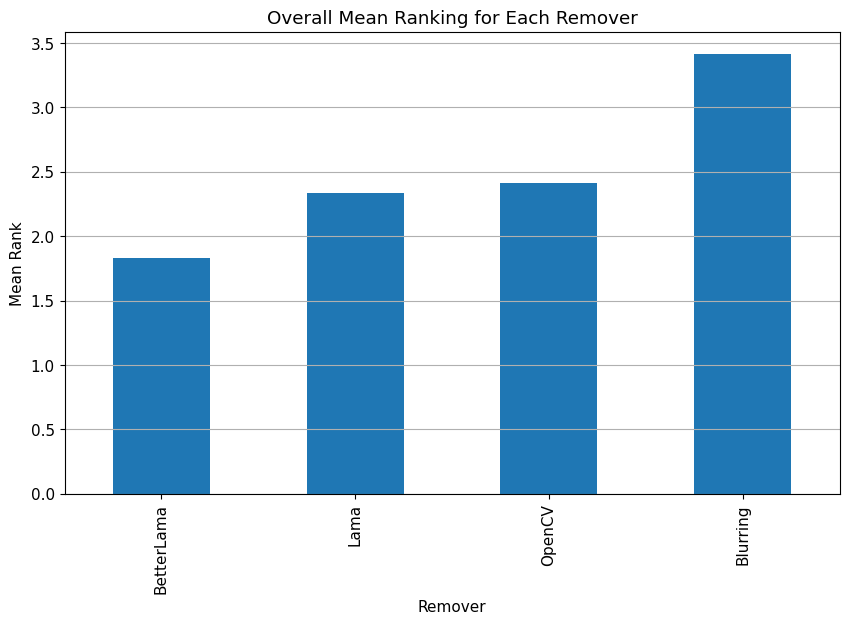

In [95]:
mean_ranking["Overall_Rank"].sort_values().plot(kind="bar", title="Overall Mean Ranking for Each Remover", figsize=(10, 6))
plt.ylabel("Mean Rank")
plt.xlabel("Remover")
plt.grid(axis="y")
plt.show()

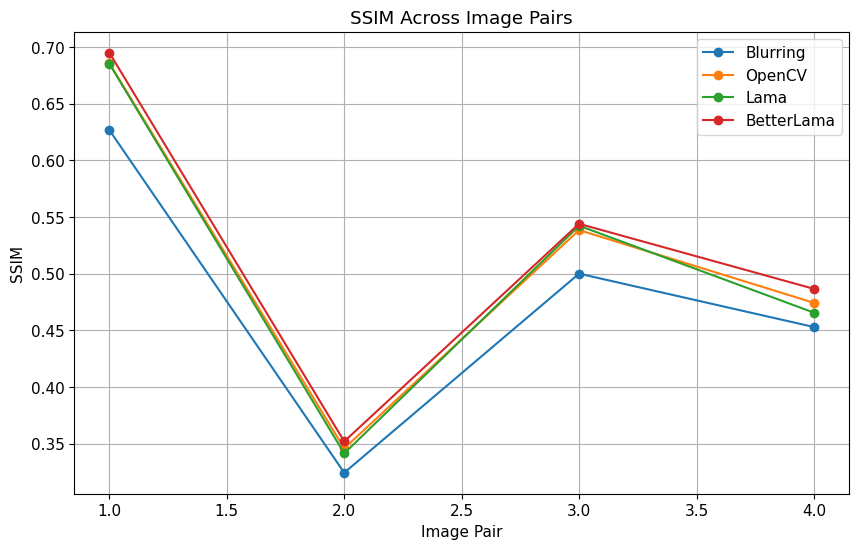

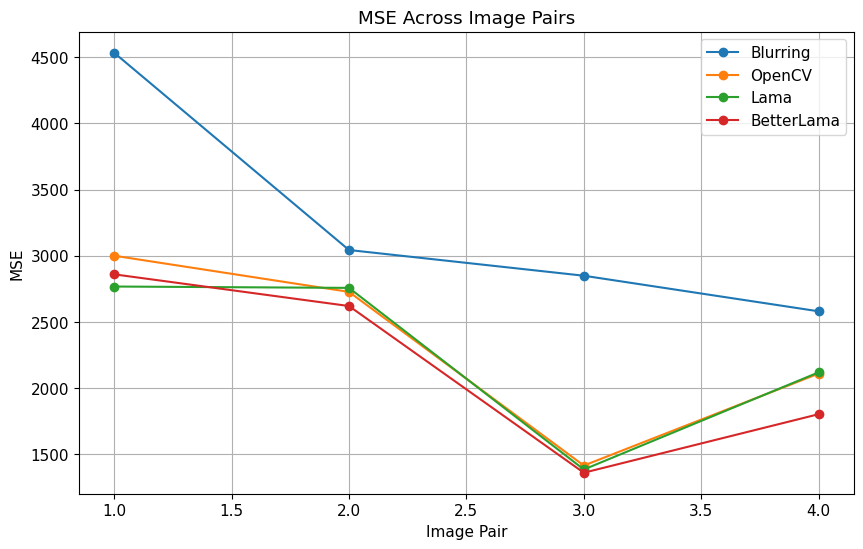

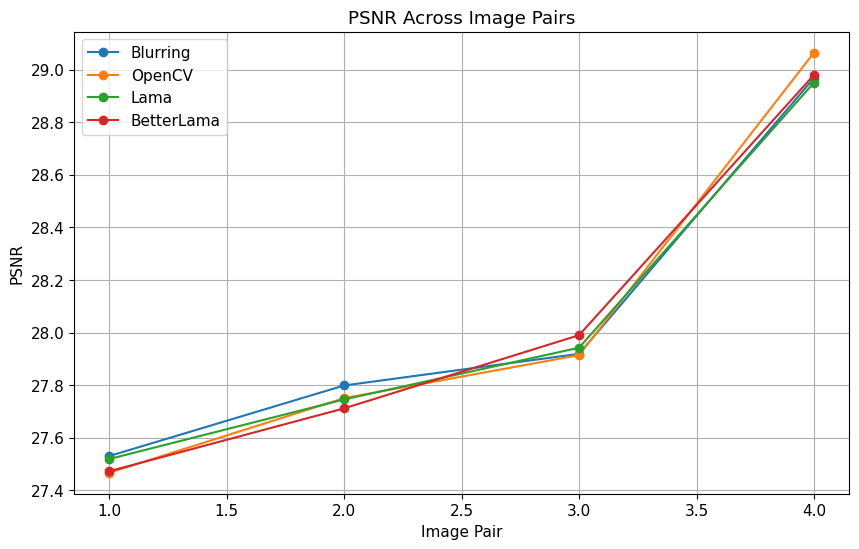

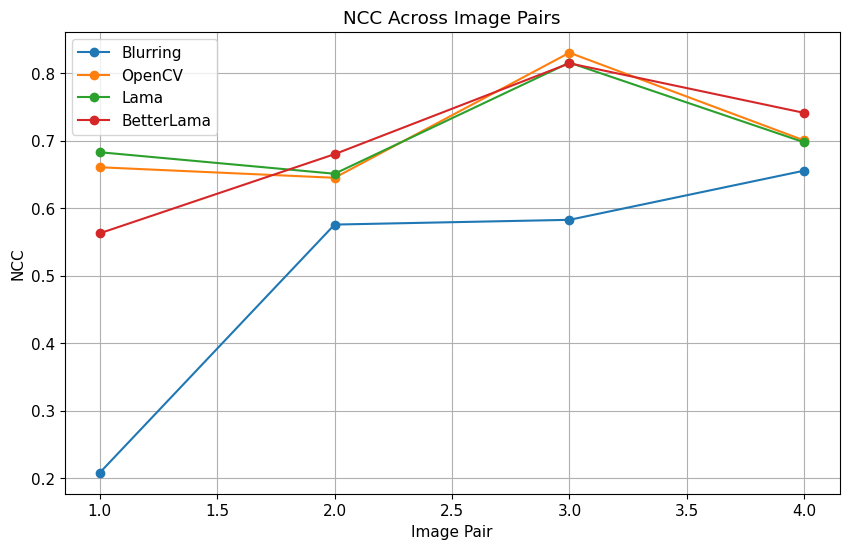

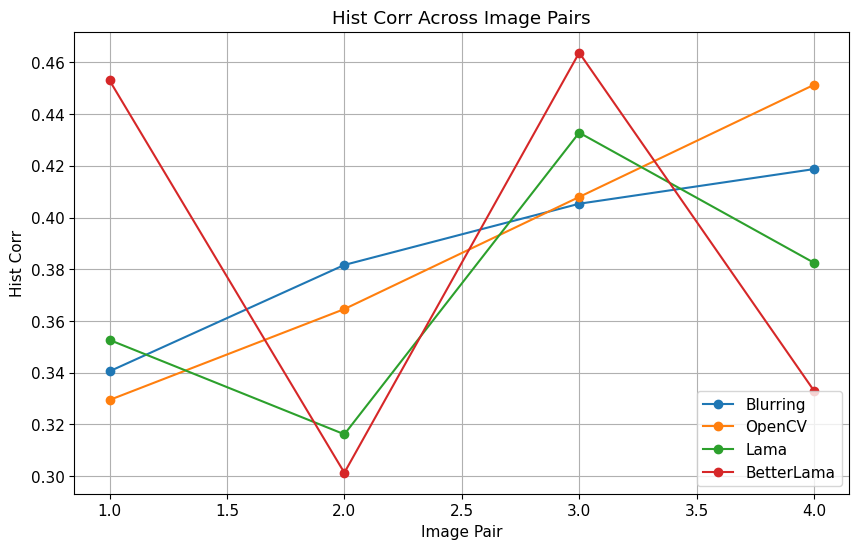

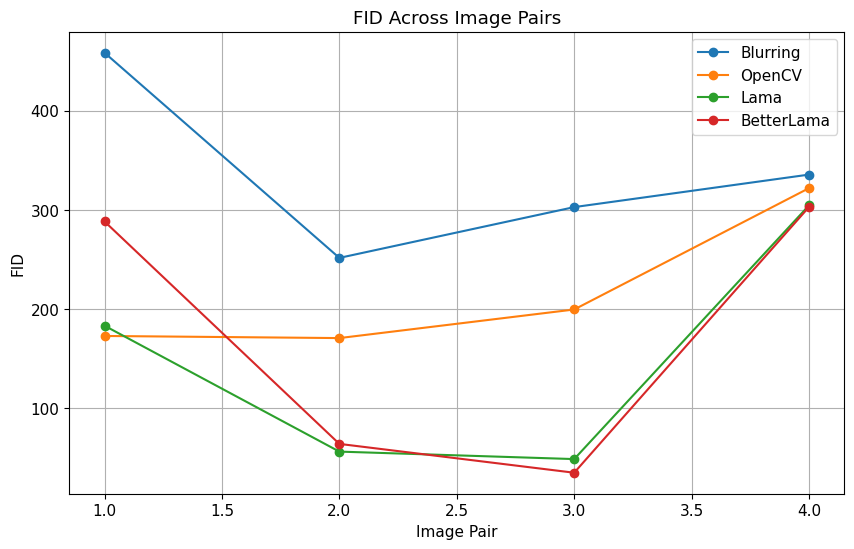

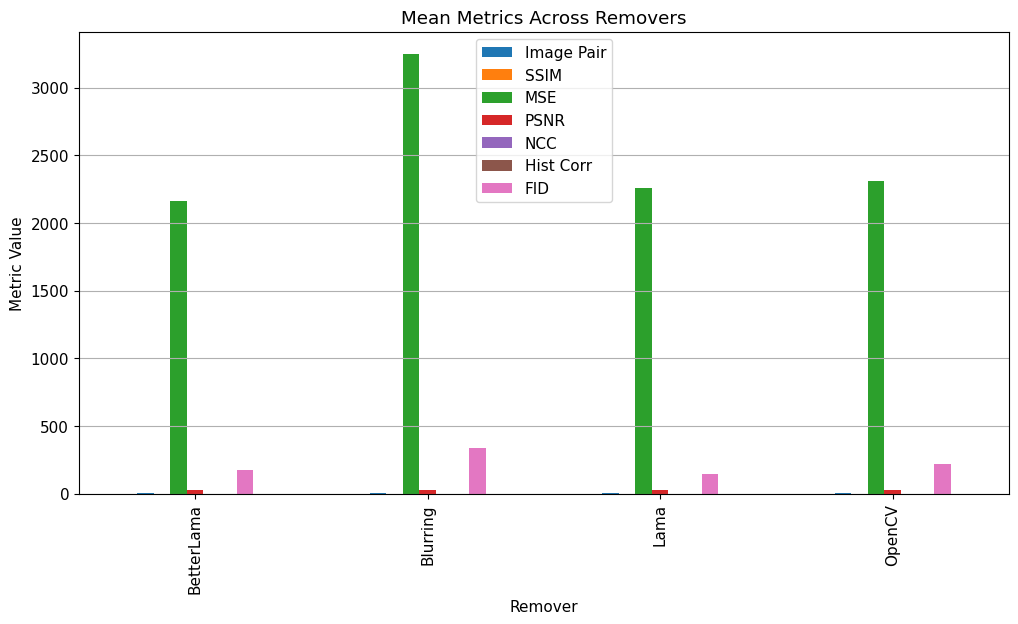

In [90]:
# List of metrics to plot
metrics = ["SSIM", "MSE", "PSNR", "NCC", "Hist Corr", "FID"]

# Generate line plots for each metric
for metric in metrics:
    plt.figure(figsize=(10, 6))
    for remover in results_df["Remover"].unique():
        remover_data = results_df[results_df["Remover"] == remover]
        plt.plot(remover_data["Image Pair"], remover_data[metric], label=remover, marker="o")
    
    plt.title(f"{metric} Across Image Pairs")
    plt.xlabel("Image Pair")
    plt.ylabel(metric)
    plt.legend()
    plt.grid(True)
    plt.show()
    
# Group by remover and calculate mean metrics
mean_results = results_df.groupby("Remover").mean()

# Plot mean metrics
mean_results.plot(kind="bar", figsize=(12, 6), title="Mean Metrics Across Removers")
plt.ylabel("Metric Value")
plt.grid(axis="y")
plt.show()

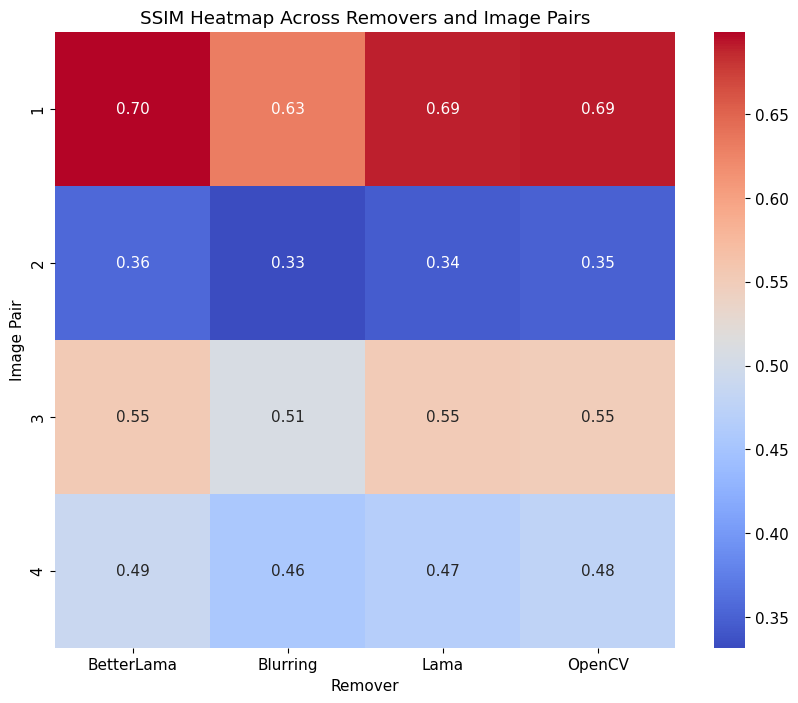

In [74]:
import seaborn as sns

# Pivot the data for the heatmap
heatmap_data = results_df.pivot("Image Pair", "Remover", "SSIM")  # Replace "SSIM" with other metrics if needed

# Plot heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(heatmap_data, annot=True, fmt=".2f", cmap="coolwarm")
plt.title("SSIM Heatmap Across Removers and Image Pairs")
plt.show()

## testing zone

In [22]:
def imshow(image, cmap=None):
  image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
  plt.imshow(image_rgb, cmap)
  plt.axis('off')  # Hide axis for better visualization
  plt.show()

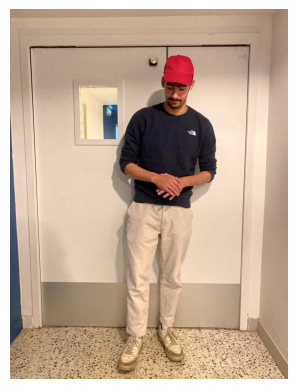

In [38]:
image_path = "../data/mathias.p/INF573_data/Remover_Benchmark/1_with_2.jpg"
detector = YOLODetector(device="cuda")
segmentor = YoloSegmentor(device="cuda")
remover = BlurringRemover()
benard_supressor = BenardSupressor(detector, segmentor, remover, None)

# Load the image
image = cv2.imread(image_path)
# display the original image
imshow(image)





Red Cap Detector Output: [(663, 198, 131, 132)]


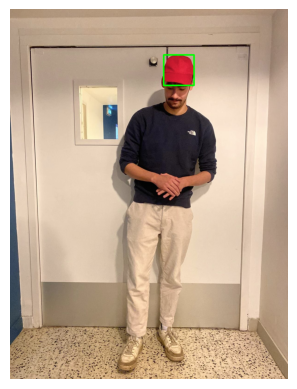

In [39]:
"""
Test if the red cap detector correctly identifies a bounding box for a red cap.
"""
red_cap_detector = RedCapDetector()

red_cap_boxes = red_cap_detector.detect_and_track(image)
print("Red Cap Detector Output:", red_cap_boxes)
# Draw the bounding box on the image knowing that the red_cap_detector returns a bounding box in the form (x, y, w, h) where the red cap is located. If no cap is found, returns None.

if red_cap_boxes is not None:
    test_image_bis = image.copy()
    for box in red_cap_boxes:
        x, y, w, h = box
        cv2.rectangle(test_image_bis, (x, y), (x+w, y+h), (0, 255, 0), 5)
        # cv2.putText(test_image_bis, 'Red Cap', (x, y-10), cv2.FONT_HERSHEY_SIMPLEX, 0.9, (0, 255, 0), 2)

    
    imshow(test_image_bis)

In [ ]:
benard_supressor.process_image(image, output_folder="../data/mathias.p/INF573_data/Remover_Benchmark", debugging_frames_level="All")

In [29]:
# Load the image
image_path = "../data/mathias.p/INF573_data/images/IMG_4792.jpeg"
image = cv2.imread(image_path)
image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  # Convert to RGB for display with matplotlib
hsv_image = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)  # Convert to HSV

# H=22.93, S=250.12, V=225.80 for image 1

# Define a function to display the box and calculate the mean HSV
def analyze_box(x: int, y: int, side: int):
    # Ensure the box doesn't go out of bounds
    h, w, _ = image.shape
    x = min(max(0, x), w - side)
    y = min(max(0, y), h - side)
    side = min(side, w - x, h - y)
    
    # Extract the box region
    box_region = hsv_image[y:y+side, x:x+side]
    
    # Calculate the mean HSV values
    mean_hsv = cv2.mean(box_region)[:3]  # Ignore the alpha channel
    mean_hsv = (mean_hsv[0], mean_hsv[1], mean_hsv[2])
    
    # Draw the box on the image
    boxed_image = image_rgb.copy()
    cv2.rectangle(boxed_image, (x, y), (x + side, y + side), (255, 0, 0), 2)
    
    # Display the image with the box
    plt.figure(figsize=(10, 10))
    plt.imshow(boxed_image)
    plt.title(f"Box at (x={x}, y={y}, side={side})")
    plt.axis("off")
    plt.show()
    
    # Print the mean HSV values
    print(f"Mean HSV values inside the box: H={mean_hsv[0]:.2f}, S={mean_hsv[1]:.2f}, V={mean_hsv[2]:.2f}")

# Interactive widget
interact(analyze_box, 
         x=(0, image.shape[1]-1, 1), 
         y=(0, image.shape[0]-1, 1), 
         side=(10, min(image.shape[0], image.shape[1]), 1));


interactive(children=(IntSlider(value=2015, description='x', max=4031), IntSlider(value=1511, description='y',…